1. 이미지 사이즈 전처리 ㅇ
    - 전처리된 이미지 불러와서 -> 텐서저장-> 1줄짜리로
2. 데이터로더 생성.

2. 딥러닝 모델 클래스 적기 (nn.Module 상속)
3. 딥러닝 모델 객체 만들어서 학습시키기 (학습, 테스트 데이터 분리)
4. 학습된 객체에 테스트 데이터 넣어서 예측값 뽑기
5. 뽑아낸 예측값 데이터 사용해서 성능평가하기
6. 이렇게 여러 클래스 모델 만들어서 학습, 평가 반복

In [85]:
# 모듈 임포트
import pandas as pd
import numpy as np
from PIL import Image
import os,sys
import torch
import torch.nn as nn
import torchviz
import matplotlib.pyplot as plt
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

In [86]:
file = 'happydog.csv'

In [87]:
happydog = pd.read_csv(file)
happydog

,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,16375,16376,16377,16378,16379,16380,16381,16382,16383,happy
0,0,199,196,196,199,207,212,214,214,195,...,249,173,241,245,255,201,134,104,50,1
1,1,186,185,202,206,193,198,198,174,152,...,188,191,206,230,229,216,223,218,184,1
2,2,241,237,233,235,240,243,242,239,239,...,241,228,234,227,232,240,231,234,240,1
3,3,158,164,148,146,162,148,136,162,145,...,131,159,132,135,112,105,78,103,115,1
4,4,166,171,176,179,183,187,188,186,183,...,145,142,149,143,117,132,134,149,122,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,995,22,23,24,25,26,26,26,26,26,...,116,110,105,96,87,82,85,94,102,0
1996,996,146,151,139,135,141,103,116,88,112,...,119,119,86,100,121,104,105,116,98,0
1997,997,93,91,74,70,88,82,70,77,93,...,141,145,169,170,170,196,208,199,196,0
1998,998,93,79,99,102,101,101,91,116,102,...,137,152,151,148,145,144,151,162,171,0


In [88]:
# feature, target 분리
feature = happydog.iloc[:, 1:-1] # 마지막 열에 붙여놓은 라벨과 Unnamed:0열 제외하고 모든 열 지정.
target = happydog.iloc[:, -1] # 마지막 열만 지정.

In [89]:
# 데이터 확인
# print(feature.shape, feature.ndim) # 2차원 데이터 (2000, 16385) 2 (128*128)
# print(target.shape, target.ndim) # 1차원 데이터 (2000,) 1

In [90]:
#feature.head(2)

In [91]:
# 0~255까지의 범위를 가진 이미지 데이터를 255로 나눠서 0과 1사이의 값으로 정규화.
feature = feature/255

데이터셋 생성

In [92]:
# 데이터셋 준비.
from sklearn.model_selection import train_test_split

Xtrn, Xtst, ytrn, ytst = train_test_split(feature, target, test_size=0.2, random_state = 10, shuffle = True, stratify = target)

Xtrn, Xval, ytrn, yval = train_test_split(feature, target, test_size=0.2, random_state=42, stratify = target)

In [93]:
# 텐서로 변환
# 바로 변환이 안돼서 넘파이로 변환 후 다시 텐서로 변환.
XtrnNP = np.array(Xtrn)
XtstNP = np.array(Xtst)
XvalNP = np.array(Xval)
yvalNP = np.array(yval)
ytrnNP = np.array(ytrn)
ytstNP = np.array(ytst)

Xtrain = torch.FloatTensor(XtrnNP)
Xtest = torch.FloatTensor(XtstNP)
Xval = torch.FloatTensor(XvalNP)
yval = torch.FloatTensor(yvalNP)
ytrain = torch.FloatTensor(ytrnNP)
ytest = torch.FloatTensor(ytstNP)

In [94]:
print(f'Xtrain = {Xtrain.shape}, {Xtrain.ndim}')
print(f'Xtest = {Xtest.shape}, {Xtest.ndim}')
print(f'Xtest = {Xval.shape}, {Xval.ndim}')
print(f'ytrain = {ytrain.shape}, {ytrain.ndim}')
print(f'ytrain = {yval.shape}, {yval.ndim}')
print(f'ytest = {ytest.shape}, {ytest.ndim}')

Xtrain = torch.Size([1600, 16384]), 2
Xtest = torch.Size([400, 16384]), 2
Xtest = torch.Size([400, 16384]), 2
ytrain = torch.Size([1600]), 1
ytrain = torch.Size([400]), 1
ytest = torch.Size([400]), 1


In [95]:
# TensorDataset 클래스 로딩
from torch.utils.data import TensorDataset

trainDS = TensorDataset(Xtrain, ytrain)
valDS = TensorDataset(Xval, yval)
testDS = TensorDataset(Xtest, ytest)

In [160]:
Xval.shape

torch.Size([400, 16384])

데이터로더 생성 : 학습용, 검증용, 테스트용

In [96]:
batch = 20
trainDL = DataLoader(trainDS, batch_size=batch)
valDL = DataLoader(valDS, batch_size=batch)
testDL = DataLoader(testDS, batch_size=batch)

In [97]:
# Epoch 당 반복 단위
print(f'batch_size : {batch}\n')
print(f'trainDS => {len(trainDS)}개 \ttestDS => {len(testDS)}개\n')
print(f'trainDS => {len(trainDS)}개 \ttestDS => {len(testDS)}개\n')
print(f'trainDL => {len(trainDL)}개 \ttestDS => {len(testDL)}개\n')

batch_size : 20

trainDS => 1600개 	testDS => 400개

trainDS => 1600개 	testDS => 400개

trainDL => 80개 	testDS => 20개



In [98]:
class LMdl(nn.Module) :
    # 구성 요소 정의
    def __init__(self, in_, out_) :
        super().__init__()
        self.layer = nn.Linear(in_, 4000)
        self.hidden_layer1 = nn.Linear(4000, 3000)
        self.hidden_layer2 = nn.Linear(3000, 2000)
        self.hidden_layer3 = nn.Linear(2000, 1000)
        self.hidden_layer4 = nn.Linear(1000, 500)
        self.hidden_layer5 = nn.Linear(500, 250)
        self.hidden_layer6 = nn.Linear(250, 125)
        self.out_layer = nn.Linear(125, out_)
        self.relu = nn.ReLU()

    def forward(self, x) :
        y = self.layer(x)
        z = self.relu(y)
        y = self.hidden_layer1(z)
        z = self.relu(y)
        y = self.hidden_layer2(z)
        z = self.relu(y)
        y = self.hidden_layer3(z)
        z = self.relu(y)
        y = self.hidden_layer4(z)
        z = self.relu(y)
        y = self.hidden_layer5(z)
        z = self.relu(y)
        y = self.hidden_layer6(z)
        z = self.relu(y)
        y = self.out_layer(z)
        z = self.relu(y)

        return y

[5] 학습 준비 : 실행 디바이스, 모델, 최적화, 손실함수 학습횟수, 학습함수, 평가함수, 예측 함수

In [99]:
# 실행 디바이스 실행.
DEVICE = 'cuda'if torch.cuda.is_available() else 'cpu'

# 학습 횟수
EPOCHS = 10

In [100]:
in_, out_ = Xtrain.shape[1], 1 # 이진분류

In [101]:
mdl = LMdl(in_, out_)
mdl = LMdl(in_,out_).to(DEVICE)
# print(mdl)

In [102]:
import torch.optim as optim
import torch.nn.functional as F


In [103]:
# 최적화 인스턴스 생성 => 모델에서 사용하는 w와 b 변수들 전달 
optimizer=optim.Adam(mdl.parameters()) 

In [104]:
# # # 학습 진행 함수 
# def training() :
#     global ytrain
#     global EPOCHS

#     loss_accuracy = [[], []] # [0]에는 오차가 담기고 [1]에는 훈련 정확도가 입력됨.
#     for idx, (feature, target) in enumerate(trainDL) :
#         feature, target = feature.to(DEVICE), target.to(DEVICE)


#     for ep in range(EPOCHS):
#         # 학습
#         pre_y = mdl(feature) 
#         # pre_y = mdl(Xtrn)에서는 실제로 입력 데이터인 Xtrn을 사용하여 예측값을 계산
#         # print(f"예측값 : {pre_y}")
        
#         # 분류값 변화
#         pre_y2 = F.sigmoid(pre_y)
#         # 시그모이드 함수는 입력값을 [0, 1] 범위로 변환하는 비선형 함수.
#         # 이 함수는 주로 이진 분류 문제에서 확률을 계산하기 위해 사용.
#         #print(f"분류값 : {pre_y2}")
            
#         # 오차 즉 손실 계산
#         pre_y2 = pre_y2.unsqueeze(dim=1)
#         #target = target.unsqueeze(dim=1)
#         loss = F.binary_cross_entropy(pre_y2, target) # (예측값, 정답)
#         #loss_list.append(loss.item())
#         loss_accuracy[0].append(loss.item())
#         print(f'[{ep+1}] Loss => {loss}')
        
#         # W, b 업데이트
#         optimizer.zero_grad() # 초기화
#         loss.backward()  # 손실함수 계산값으로 미분 진행하여 새로운 W, b 계산
#         optimizer.step() # 새로운 값으로 W, b 업데이트
        
#         # 정확도 계산 => 예측값을 0과 1로 변환 ==> 정답과 비교
#         train_accuracy = ((target == (pre_y2 >= 0.5)).sum() )/ target.shape[0]
#         # 예측값이 0.5보다 클 때의 정답의 값을 더한 것 / 60000
#         loss_accuracy[1].append(train_accuracy) # 훈련용 데이터 정확도.

#     return loss_accuracy

In [159]:
valDS.dataset

AttributeError: 'TensorDataset' object has no attribute 'dataset'

In [161]:
# # 학습 진행 함수 
def training() :

    for idx, (feature, target) in enumerate(trainDL) :
        feature, target = feature.to(DEVICE), target.to(DEVICE)

        # 학습
        mdl.train()
        pre_y = mdl(feature) 
        
        # 분류값 변화
        pre_y2 = F.sigmoid(pre_y)
        # 출력을 0과 1 사이의 값으로 변환하는 활성화 함수
        # 주어진 입력에 대해 출력을 0에서 1 사이의 값으로 압축. 
        # 일반적으로 이진 분류 문제에서 확률 값을 출력하기 위해 사용. 
        # 출력 값이 0.5보다 크면 1로 분류되고, 작으면 0으로 분류.

        # 오차 즉 손실 계산
        # pre_y2 = pre_y2.unsqueeze(dim=1)
        target = target.unsqueeze(dim=1)
        # print(f"손실함수 계산 전 shape 확인 => pre_y2 : {pre_y2.shape}  target : {target.shape}")
        loss = F.binary_cross_entropy(pre_y2, target) # (예측값, 정답)

        # print(f' Loss => {loss}')
        
        # W, b 업데이트
        optimizer.zero_grad() # 초기화
        loss.backward()  # 손실함수 계산값으로 미분 진행하여 새로운 W, b 계산
        optimizer.step() # 새로운 값으로 W, b 업데이트
        
        # 정확도 계산 => 예측값을 0과 1로 변환 ==> 정답과 비교
        train_accuracy = ((target == (pre_y2 >= 0.5)).sum() )/ target.shape[0]
    # 예측값이 0.5보다 클 때의 정답의 값을 더한 것 / 60000
   
    return loss.item(), train_accuracy

train_loss = training()

In [162]:
train_loss

(0.6900888681411743, tensor(0.6000))

In [124]:
loss_list = []
acc_list = []
for ep in range(EPOCHS):
    sample = []
    train_loss, train_accuracy = training()
    print(f"ep [{ep+1}] {train_loss}")
    loss_list.append(train_loss)
    acc_list.append(train_accuracy)

ep [1] 0.6201683878898621
ep [2] 0.6103105545043945
ep [3] 0.5626925230026245
ep [4] 0.3586547076702118
ep [5] 0.7552832365036011
ep [6] 0.34918227791786194
ep [7] 0.39070528745651245
ep [8] 0.4682343006134033
ep [9] 0.4888514578342438
ep [10] 0.3919946849346161


In [107]:
print(len(loss_list), len(acc_list))

10 10


In [108]:
epoch_list = []
for i in range(10):
    epoch_list.append(i)


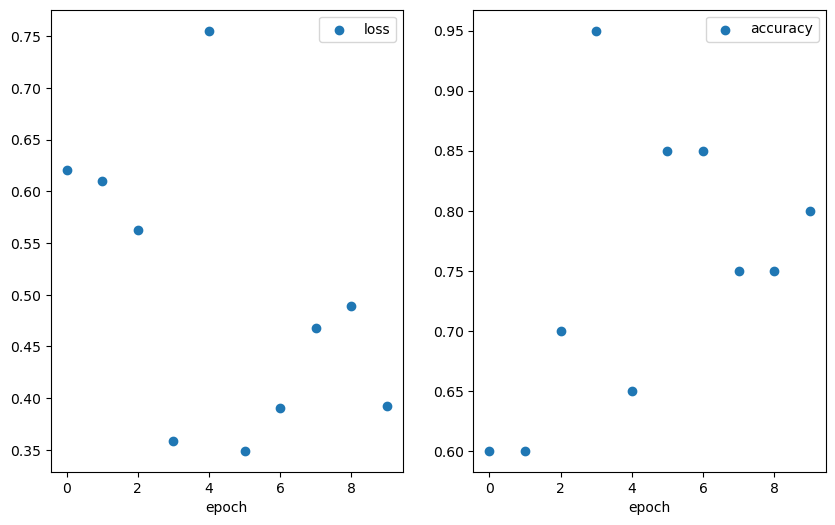

In [142]:
import matplotlib.pyplot as plt

plt.figure(figsize = (10, 6))
plt.subplot(1,2,1)
plt.scatter(epoch_list, loss_list, label = 'loss') #학습(epoch)에 따른 손실(loss) 변화
plt.legend()
plt.xlabel('epoch')

plt.subplot(1,2,2)
plt.scatter(epoch_list, acc_list, label = 'accuracy') #왼쪽 그래프(1번째 subplot): 학습(epoch)에 따른 정확도 변화
plt.legend()
plt.xlabel('epoch')

plt.show()

In [170]:
# 학습 진행 함수 
def Val() :
    mdl.eval()
    with torch.no_grad():
        lossList = []
        for _, (feature, target) in enumerate(valDL) :
            feature, target = feature.to(DEVICE), target.to(DEVICE)

            # 학습
            pre_yval = mdl(feature) 
            # pre_y = mdl(Xtrn)에서는 실제로 입력 데이터인 Xtrn을 사용하여 예측값을 계산
            
            # 분류값 변화
            pre_yval2 = F.sigmoid(pre_yval)
            # 시그모이드 함수는 입력값을 [0, 1] 범위로 변환하는 비선형 함수.
            # 이 함수는 주로 이진 분류 문제에서 확률을 계산하기 위해 사용.

            #print('손실 계산 전', pre_yval2.shape, target.shape)   
            # 오차 즉 손실 계산
            
            target = target.unsqueeze(dim=1) # 사이즈가 안맞아서
            #pre_yval2 = pre_yval2.unsqueeze(dim=1)
            loss = F.binary_cross_entropy(pre_yval2, target) # (예측값, 정답)
            lossList.append(loss.item())
            
            # 정확도 계산 => 예측값을 0과 1로 변환 ==> 정답과 비교
            val_accuracy = ((target == (pre_yval2 >= 0.5)).sum())/target.shape[0]
            # 예측값이 0.5보다 클 때의 정답의 값을 더한 것 
    return lossList, val_accuracy


loss_list_val = []
acc_list_val = []
for ep in range(EPOCHS):
    val_loss, val_accuracy = Val()
    print(f"ep [{ep+1}] val_loss: {val_loss[ep]}, val_accuracy: {val_accuracy}")
    loss_list_val.append(val_loss)
    acc_list_val.append(val_accuracy)
#print(loss_list_val)



ep [1] val_loss: 0.6941688060760498, val_accuracy: 0.550000011920929
ep [2] val_loss: 0.692815899848938, val_accuracy: 0.550000011920929
ep [3] val_loss: 0.6946558356285095, val_accuracy: 0.550000011920929
ep [4] val_loss: 0.696661114692688, val_accuracy: 0.550000011920929
ep [5] val_loss: 0.6948517560958862, val_accuracy: 0.550000011920929
ep [6] val_loss: 0.6928719878196716, val_accuracy: 0.550000011920929
ep [7] val_loss: 0.6942455172538757, val_accuracy: 0.550000011920929
ep [8] val_loss: 0.6920737028121948, val_accuracy: 0.550000011920929
ep [9] val_loss: 0.6915575861930847, val_accuracy: 0.550000011920929
ep [10] val_loss: 0.6937552690505981, val_accuracy: 0.550000011920929


ValueError: x and y must be the same size

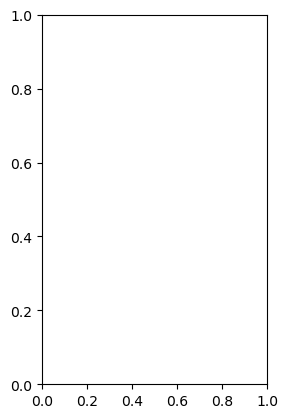

In [176]:
import matplotlib.pyplot as plt

plt.subplot(1,2,1)
plt.scatter(epoch_list, loss_list_val, label = 'loss')
plt.legend()
plt.xlabel('epoch')

plt.subplot(1,2,2)
plt.scatter(epoch_list, acc_list_val, label = 'accuracy')
plt.legend()
plt.xlabel('epoch')

plt.show()



In [174]:
def test() :
    mdl.eval()
    with torch.no_grad():
        loss_list=[]
        for _, (feature, target) in enumerate(testDL) :
            feature, target = feature.to(DEVICE), target.to(DEVICE)

            pre_ytst = mdl(feature)
            # 분류값 변화
            pre_ytst2 = F.sigmoid(pre_ytst)

                
            # 오차 즉 손실 계산
            #pre_ytst2 = pre_ytst2.unsqueeze(dim=1)
            target = target.unsqueeze(dim=1)
            loss = F.binary_cross_entropy(pre_ytst2, target) # (예측값, 정답)
            loss_list.append(loss.item())
            #print(f'[{idx+1}] Loss => {loss}')
            
            
            # 정확도 계산 => 예측값을 0과 1로 변환 ==> 정답과 비교
            test_accuracy = ((target == (pre_ytst2 >= 0.5)).sum())/ target.shape[0]
            # 예측값이 0.5보다 클 때의 정답의 값을 더한 것 / 60000


        return loss_list, test_accuracy


loss_list_tst = []
acc_list_tst = []
for ep in range(EPOCHS):
    tst_loss, tst_accuracy = test()
    print(f"ep [{ep+1}] {tst_loss[ep]}, {tst_accuracy}")
    loss_list_tst.append(tst_loss)
    acc_list_tst.append(tst_accuracy)

ep [1] 0.6924001574516296, 0.5
ep [2] 0.6926509141921997, 0.5
ep [3] 0.69448322057724, 0.5
ep [4] 0.6955350637435913, 0.5
ep [5] 0.6952961683273315, 0.5
ep [6] 0.6925681233406067, 0.5
ep [7] 0.6937823295593262, 0.5
ep [8] 0.6939720511436462, 0.5
ep [9] 0.6937996745109558, 0.5
ep [10] 0.6942533254623413, 0.5


In [137]:
# threshold = 0.5
# ypre = (mdl(Xtest) >= threshold).float()
# ypre

In [127]:
torch.save(mdl.state_dict(), 'model.pth')

In [128]:
#mdl.load_state_dict(torch.load('model.pth'))

<All keys matched successfully>

In [190]:
path = './Dog Emotion/dog_angry.jpg'
path2 = './Dog Emotion/dogy.png'

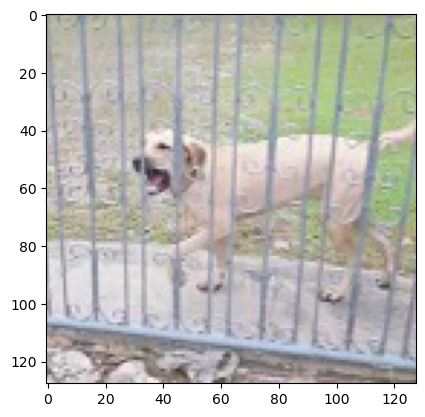

In [188]:
dogimg = Image.open(path)
plt.imshow(dogimg, cmap='gray')


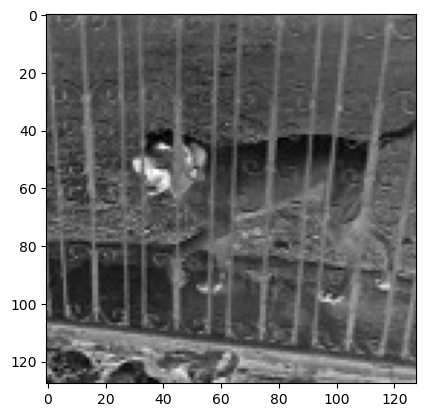

In [189]:
dogimg = dogimg.convert('L')
dogimg = np.array(dogimg)
dogimg = abs(dogimg.astype('int')-255)

plt.imshow(dogimg, cmap='gray')

In [201]:
dogimg = dogimg.flatten()


In [202]:
mdl.eval() 
dogimgTensor = torch.Tensor(dogimg)
with torch.no_grad():
    output = mdl(dogimgTensor)
    predicted_class = torch.round(output).item()  # 0 또는 1로 예측 결과를 이진 분류로 변환
    if predicted_class == 1:
        print("이 강아지는 행복합니다.")
    else:
        print("이 강아지는 행복하지 않습니다.")

이 강아지는 행복하지 않습니다.


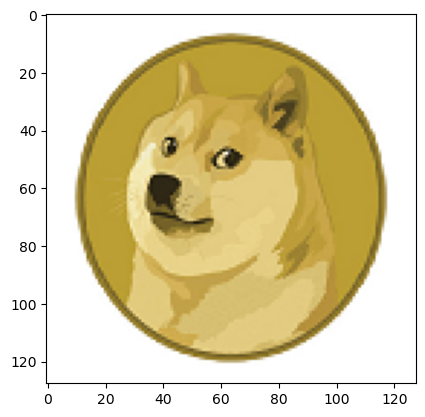

In [203]:
dogy = Image.open(path2)
plt.imshow(dogy, cmap='gray')

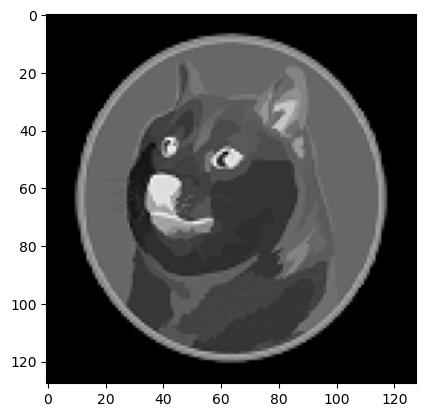

In [197]:
dogy = dogy.convert('L')
dogy = np.array(dogy)
dogy = abs(dogy.astype('int')-255)
plt.imshow(dogy, cmap='gray')

In [198]:
dogy = dogy.flatten()

In [199]:
mdl.eval() 
dogyTensor = torch.Tensor(dogy)
with torch.no_grad():
    output = mdl(dogyTensor)
    predicted_class = torch.round(output).item()  # 0 또는 1로 예측 결과를 이진 분류로 변환
    if predicted_class == 1:
        print("이 강아지는 행복합니다.")
    else:
        print("이 강아지는 행복하지 않습니다.")

이 강아지는 행복하지 않습니다.
